# Import libraries

In [64]:
import numpy as np
import pandas as pd
import spacy
import re
import string
import inflect
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import SnowballStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import spacy
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')


# Data Ingestion

In [65]:
data=pd.read_csv(r'../data/reviews_badminton/data.csv')
df=data.copy()
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


# Handling Duplicates

In [67]:
df.duplicated().sum()

4

In [68]:
df.drop_duplicates(inplace=True)

In [69]:
df.duplicated().sum()

0

# Handling Missing Values


In [70]:
df.isna().sum()

Reviewer Name        6
Review Title         6
Place of Review     46
Up Votes             6
Down Votes           6
Month              461
Review text          4
Ratings              0
dtype: int64

In [71]:
df.dropna(inplace=True)

In [72]:
df.isna().sum()

Reviewer Name      0
Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Month              0
Review text        0
Ratings            0
dtype: int64

# Feature Engineering

## Removing review name column

In [73]:
df.drop(columns='Reviewer Name',inplace=True)

## Creating a new feature out of title and review text

In [74]:
# Combine title and review text as one review
df['Review'] = df['Review Title'] + ' ' + df['Review text']

In [75]:
# Remove title and review text column
df.drop(columns=['Review Title','Review text'],inplace=True)

## Handling Place of Review

In [76]:
# Unique type of buyers
df['Place of Review'].str.split(',').str[0].unique()

array(['Certified Buyer'], dtype=object)

In [77]:
df['Place of Review'].str.split(',').str[1].unique()

array([' Chirakkal', ' Hyderabad', ' Dharmapuri', ..., ' Thiruppuvanam',
       ' Singaperumal Koil', ' Raebareli'], dtype=object)

In [78]:
len(df['Place of Review'].str.split(',').str[1].unique())

2262

### Observation
- There is only one type of buyer and there are more 2262 places where orders originated. So this column has no prominence due to it's sheer variability

In [79]:
# Removing place of review
df.drop(columns='Place of Review',inplace=True)

## Handling Month Column

In [80]:
df['Month']

0       Feb 2021
1       Feb 2021
2       Apr 2021
5       Oct 2018
6       Jan 2020
          ...   
8495    Oct 2016
8496    Oct 2016
8497    Oct 2016
8499    Dec 2015
8507    Sep 2016
Name: Month, Length: 8013, dtype: object

In [81]:
df['Month'].str.split(' ').str[0].unique()

array(['Feb', 'Apr', 'Oct', 'Jan', 'Aug', 'May', 'Jun', 'Sep', 'Mar',
       'Jul', 'Nov', 'Dec'], dtype=object)

In [82]:
df['Month'].str.split(' ').str[1].unique()

array(['2021', '2018', '2020', '2016', '2019', '2022', '2017', '2015'],
      dtype=object)

In [83]:
df['Year'] = df['Month'].str.split(' ').str[1]


In [84]:
df['Month'] = df['Month'].str.split(' ').str[0]


In [85]:
df

,Up Votes,Down Votes,Month,Ratings,Review,Year
0,889.0,64.0,Feb,4,"Nice product Nice product, good quality, but p...",2021
1,109.0,6.0,Feb,1,Don't waste your money They didn't supplied Yo...,2021
2,42.0,3.0,Apr,1,Did not meet expectations Worst product. Damag...,2021
5,173.0,45.0,Oct,5,Mind-blowing purchase Good quality product. De...,2018
6,403.0,121.0,Jan,5,Must buy! BEST PURCHASE It is a good quality a...,2020
...,...,...,...,...,...,...
8495,0.0,0.0,Oct,5,Nice Thanks to the delivery boy ... Service is...,2016
8496,0.0,0.0,Oct,1,Good choice Over priced even after 50% discoun...,2016
8497,0.0,0.0,Oct,1,Awesome Too much priced. It was getting me for...,2016
8499,0.0,0.0,Dec,5,High cost Hii flipkart customers care..why you...,2015


## Create a New feature reflecting the sentiment of the review

In [86]:
def getSentiment(x):
    if x<=2: return 'Negative'
    elif x==3: return 'Neutral'
    else: return 'Positive'
    
df['Sentiment']=df['Ratings'].apply(getSentiment)

In [87]:
# Save the cleaned data in a new csv file called cleaned reviews.csv 
df.to_csv(r'../data/cleaned_reviews.csv')

# EDA

## Up Votes

c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


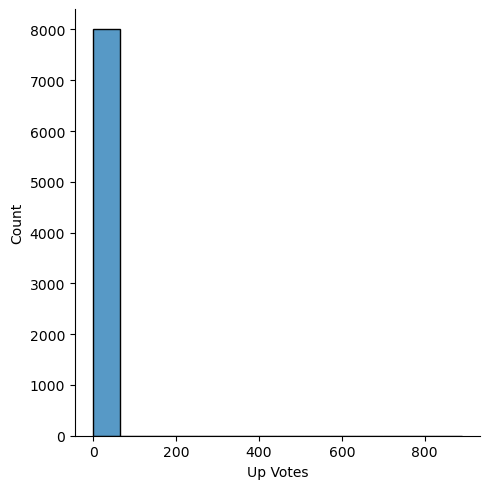

In [88]:
sns.displot(data=df,x='Up Votes')

c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Up Votes'>

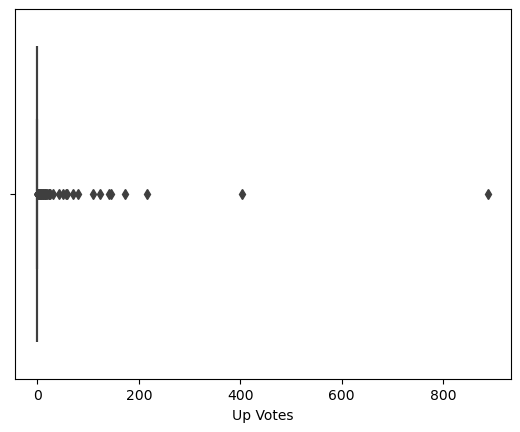

In [89]:
sns.boxplot(x=df['Up Votes'])

In [90]:
df['Up Votes'].describe()

count    8013.000000
mean        0.386747
std        11.849649
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       889.000000
Name: Up Votes, dtype: float64

### Observation
- More than 75 % of reviews has not received any kind of upvotes

 ## DownVotes

c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


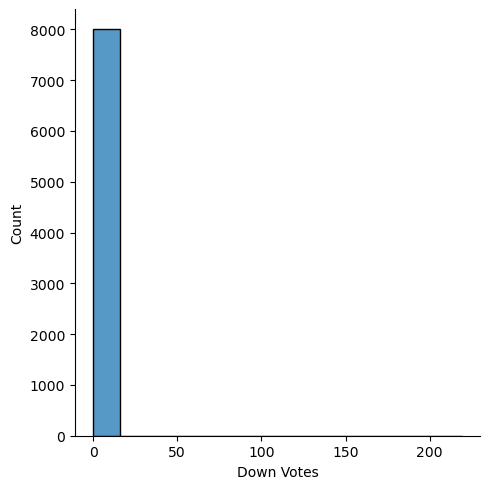

In [91]:
sns.displot(x=df['Down Votes'])

c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Down Votes'>

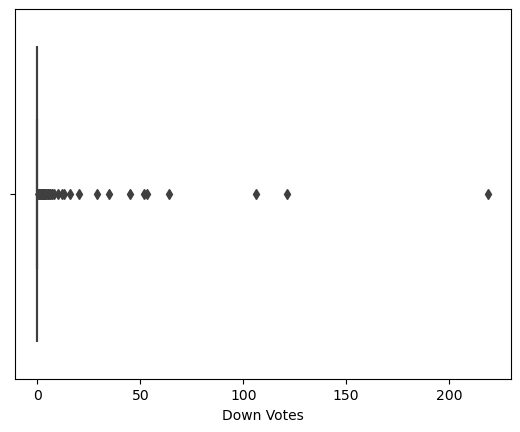

In [92]:
sns.boxplot(x=df['Down Votes'])

In [93]:
df['Down Votes'].describe()

count    8013.000000
mean        0.123424
std         3.334320
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       219.000000
Name: Down Votes, dtype: float64

### Observations
- More than 75% of reviews were not downvoted


## Month

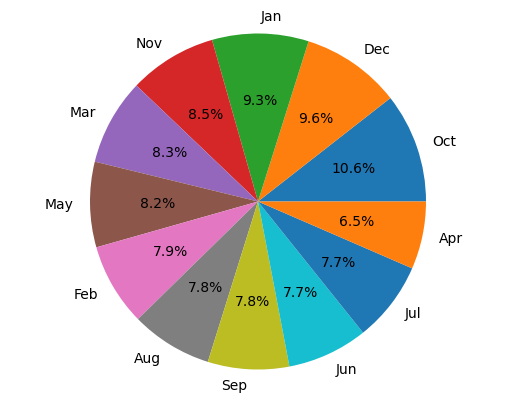

In [94]:
plt.pie(df['Month'].value_counts(), labels=df['Month'].value_counts().index, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Observations
- 10.6% of the reviews were given in the month of October
- But it seems, every month have roughly equal share of reviews


## Year

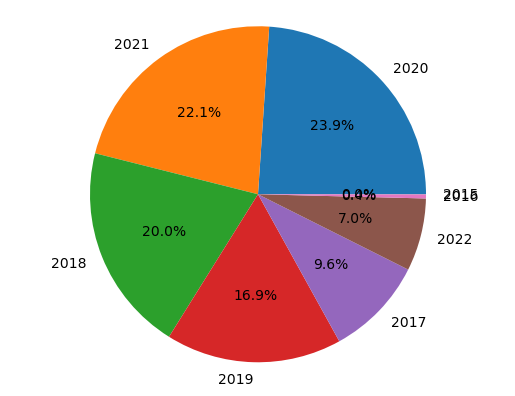

In [95]:
plt.pie(df['Year'].value_counts(), labels=df['Year'].value_counts().index, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Observation
- There was steady increase in reviews aks sales from 2016 till 2020. But there was a sudden dip after 2020

## Ratings

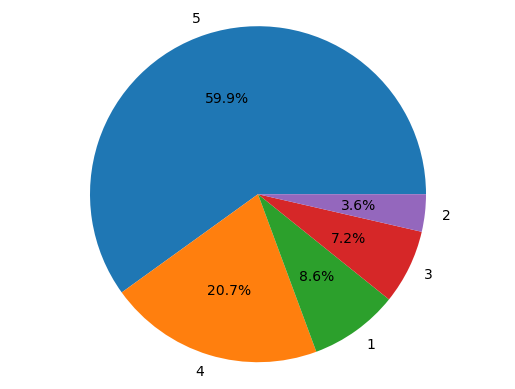

In [96]:
plt.pie(df['Ratings'].value_counts(), labels=df['Ratings'].value_counts().index, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Observations
- 80.7% of ratings were in (4,5) . This proves that product is preety much popular among consumers

### Is there any relationship between ratings and year and month

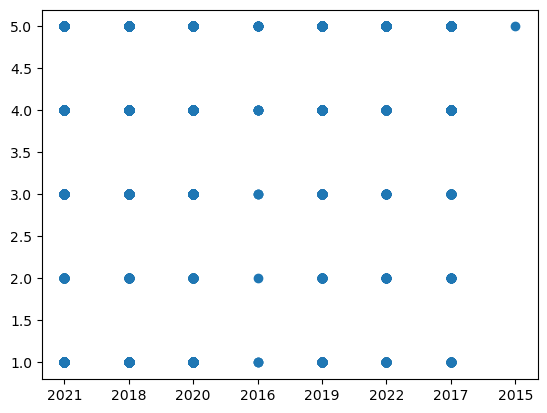

In [97]:
#Relationship between year and rating
plt.scatter(df['Year'],df['Ratings'])

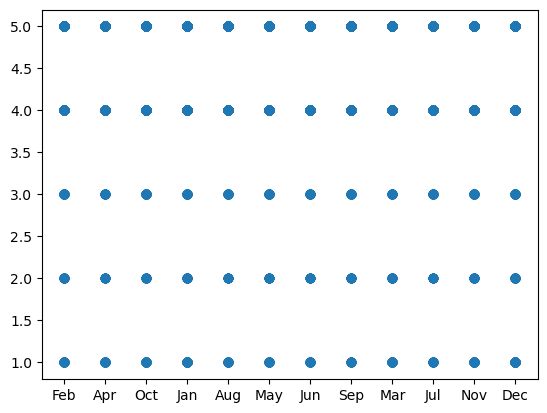

In [98]:
#Relationship between month and rating
plt.scatter(df['Month'],df['Ratings'])


### Relation between upvotes, downvotes and rating

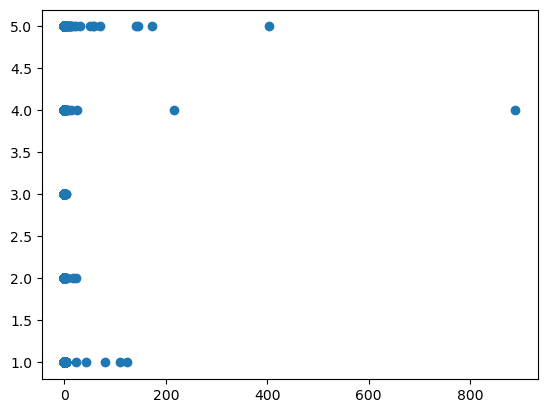

In [99]:
# relation between upvotes and rating
plt.scatter(df['Up Votes'],df['Ratings'])

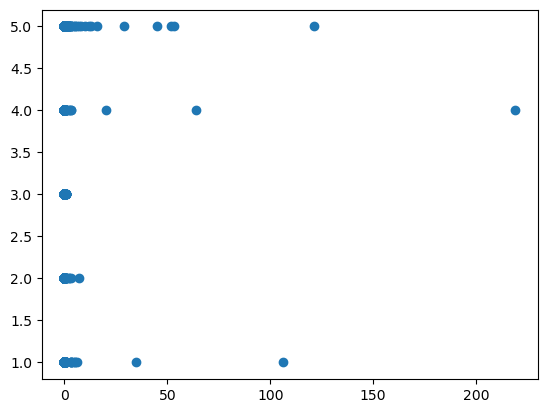

In [100]:
# relation between downvotes and ratings
plt.scatter(df['Down Votes'],df['Ratings'])

In [101]:
df[['Up Votes','Down Votes']]

,Up Votes,Down Votes
0,889.0,64.0
1,109.0,6.0
2,42.0,3.0
5,173.0,45.0
6,403.0,121.0
...,...,...
8495,0.0,0.0
8496,0.0,0.0
8497,0.0,0.0
8499,0.0,0.0


### How many reviews were neither upvoted nor downvoted

In [102]:
(len(df[(df['Up Votes']==0) & (df['Down Votes']==0)])/8013)*100

96.96742792961437

### Relation ship beteen month year and sentiment

c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

<Axes: xlabel='Month', ylabel='count'>

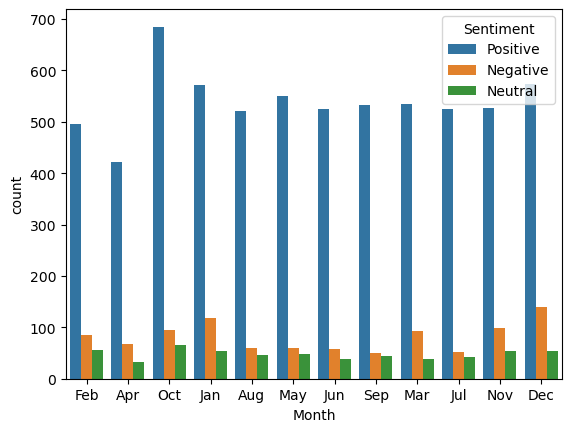

In [103]:
sns.countplot(x=df['Month'],hue=df['Sentiment'])

In [104]:
np.sort(df['Year'].unique())

array(['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'],
      dtype=object)

c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Year', ylabel='count'>

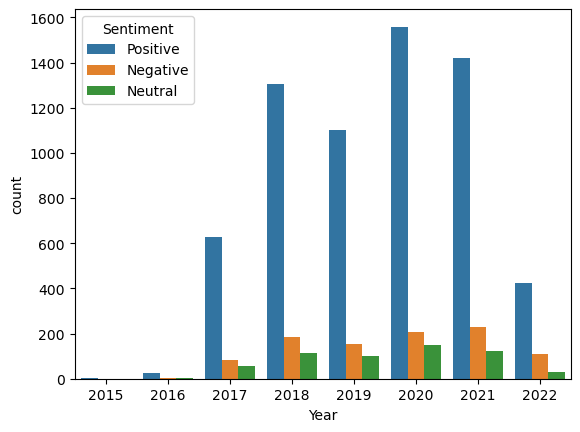

In [105]:
sns.countplot(x=df['Year'],hue=df['Sentiment'],order=np.sort(df['Year'].unique()))

In [106]:
# Let's create a new dataframe
years=np.sort(df['Year'].unique())

def getPercentages(years):
    negatives, neutrals, positives=[],[],[]
    for year in years:
        total=df[df['Year']==year].shape[0]
        negative=df[(df['Year']==year) & (df['Sentiment']=='Negative')].shape[0]
        positive=df[(df['Year']==year) & (df['Sentiment']=='Positive')].shape[0]
        neutral=df[(df['Year']==year) & (df['Sentiment']=='Neutral')].shape[0]
        negatives.append((negative/total)*100)
        neutrals.append((neutral/total)*100)
        positives.append((positive/total)*100)
    return negatives,neutrals,positives

negatives,neutrals,positives=getPercentages(years)
print(negatives,neutrals,positives)

[0.0, 12.903225806451612, 10.835509138381202, 11.519302615193027, 11.35693215339233, 10.896767466110532, 13.021420518602028, 19.607843137254903] [0.0, 9.67741935483871, 7.310704960835509, 7.160647571606475, 7.448377581120943, 7.820646506777893, 6.820744081172492, 5.169340463458111] [100.0, 77.41935483870968, 81.8537859007833, 81.3200498132005, 81.19469026548673, 81.28258602711156, 80.15783540022548, 75.22281639928698]


In [107]:
rating_per_year=pd.DataFrame(data={"Year":years,"Negative":negatives,"Neutral":neutrals,"Positive":positives})
rating_per_year

,Year,Negative,Neutral,Positive
0,2015,0.000000,0.000000,100.000000
1,2016,12.903226,9.677419,77.419355
2,2017,10.835509,7.310705,81.853786
3,2018,11.519303,7.160648,81.320050
4,2019,11.356932,7.448378,81.194690
5,2020,10.896767,7.820647,81.282586
6,2021,13.021421,6.820744,80.157835
7,2022,19.607843,5.169340,75.222816


In [108]:
rating_per_year['Pos-Neg']=rating_per_year['Positive']-rating_per_year['Negative']
rating_per_year

,Year,Negative,Neutral,Positive,Pos-Neg
0,2015,0.000000,0.000000,100.000000,100.000000
1,2016,12.903226,9.677419,77.419355,64.516129
2,2017,10.835509,7.310705,81.853786,71.018277
3,2018,11.519303,7.160648,81.320050,69.800747
4,2019,11.356932,7.448378,81.194690,69.837758
5,2020,10.896767,7.820647,81.282586,70.385819
6,2021,13.021421,6.820744,80.157835,67.136415
7,2022,19.607843,5.169340,75.222816,55.614973


c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dsai9\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Year', ylabel='Negative'>

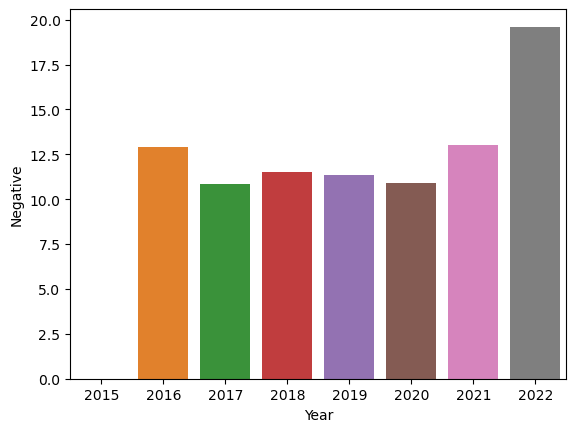

In [109]:
sns.barplot(data=rating_per_year,x='Year',y='Negative')

### Observation
- From 2021 onwards, the percentage of negative reviews has shot up significantly.

In [110]:
# Create a new df
new_df=df[['Review','Sentiment']].copy()
new_df

,Review,Sentiment
0,"Nice product Nice product, good quality, but p...",Positive
1,Don't waste your money They didn't supplied Yo...,Negative
2,Did not meet expectations Worst product. Damag...,Negative
5,Mind-blowing purchase Good quality product. De...,Positive
6,Must buy! BEST PURCHASE It is a good quality a...,Positive
...,...,...
8495,Nice Thanks to the delivery boy ... Service is...,Positive
8496,Good choice Over priced even after 50% discoun...,Negative
8497,Awesome Too much priced. It was getting me for...,Negative
8499,High cost Hii flipkart customers care..why you...,Positive


In [111]:
new_df['Sentiment']=new_df['Sentiment'].map({'Neutral':1,'Positive':1,'Negative':0})
new_df

,Review,Sentiment
0,"Nice product Nice product, good quality, but p...",1
1,Don't waste your money They didn't supplied Yo...,0
2,Did not meet expectations Worst product. Damag...,0
5,Mind-blowing purchase Good quality product. De...,1
6,Must buy! BEST PURCHASE It is a good quality a...,1
...,...,...
8495,Nice Thanks to the delivery boy ... Service is...,1
8496,Good choice Over priced even after 50% discoun...,0
8497,Awesome Too much priced. It was getting me for...,0
8499,High cost Hii flipkart customers care..why you...,1


In [112]:
new_df.to_csv(r'../data/reviews_and_sentiment.csv')

# Applying Text Pre processing on new_df

In [113]:
def text_preprocessing(corpus,flag):
    
    # change  of numbers
    p=inflect.engine()
    corpus=re.sub(r'\d+',lambda x: p.number_to_words(x.group(0)),corpus)
    
    # remove special characters
    corpus=re.sub('[^a-zA-Z]',' ',corpus)
    
    #convert to lower case
    corpus=corpus.lower()
    
    # removal of whitespaces
    corpus=' '.join(corpus.split())

    #tokenize
    words=word_tokenize(corpus)
    if flag=="stemming":
    #stemming
        stemmer=SnowballStemmer(language='english')
        return ' '.join(stemmer.stem(word) for word in words if word not in set(nltk.corpus.stopwords.words('english')))
    else:
    #lemmatization
        lemmatizer=WordNetLemmatizer()
        return ' '.join(lemmatizer.lemmatize(word) for word in words if word not in set(nltk.corpus.stopwords.words('english')))


#flag is either "stemming" or "lemmatization"


In [114]:
new_df['Review']=new_df['Review'].apply(lambda x: text_preprocessing(x,flag="stemming"))

# Text Vectorization

In [115]:
nlp=spacy.load('en_core_web_lg')

In [116]:
new_df['Vector']=new_df['Review'].apply(lambda x: nlp(x).vector)
new_df

KeyboardInterrupt: 

# Split the data

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(new_df['Vector'],new_df['Sentiment'],test_size=0.2)
print(X_train.shape,X_test.shape)

(6410,) (1603,)


In [ ]:
X_train_stack = np.stack(X_train)
X_test_stack = np.stack(X_test)
print(X_train_stack.shape,X_test_stack.shape)

(6410, 300) (1603, 300)


### Use min max scaler to scale vector values from 0 to 1

In [ ]:
scaler = MinMaxScaler()
X_train_stack_sc = scaler.fit_transform(X_train_stack)
X_test_stack_sc = scaler.transform(X_test_stack)

# Model Building

In [ ]:
model = MultinomialNB()
model.fit(X_train_stack_sc, y_train)

MultinomialNB()

In [ ]:
y_pred = model.predict(X_test_stack_sc)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
y_test

2776    1
7539    1
5394    0
4939    1
6384    1
       ..
6361    1
7744    1
4266    1
2769    1
6289    1
Name: Sentiment, Length: 1603, dtype: int64

In [ ]:
print('Accuracy Score:',accuracy_score(y_test, y_pred))


Accuracy Score: 0.8721147847785402


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       205
           1       0.87      1.00      0.93      1398

    accuracy                           0.87      1603
   macro avg       0.44      0.50      0.47      1603
weighted avg       0.76      0.87      0.81      1603



c:\Users\dsai9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsai9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\dsai9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred)

0.9316894368543819

In [117]:
new_df

,Review,Sentiment
0,nice product nice product good qualiti price r...,1
1,wast money suppli yonex mavi three hundr fifti...,0
2,meet expect worst product damag shuttlecock pa...,0
5,mind blow purchas good qualiti product deliv t...,1
6,must buy best purchas good qualiti durabl aver...,1
...,...,...
8495,nice thank deliveri boy servic alway awesom read,1
8496,good choic price even fifti discount price muc...,0
8497,awesom much price get rs six hundr forti home ...,0
8499,high cost hii flipkart custom care deliveri bo...,1


In [118]:
new_df[new_df['Sentiment']==0]

,Review,Sentiment
1,wast money suppli yonex mavi three hundr fifti...,0
2,meet expect worst product damag shuttlecock pa...,0
13,meet expect second time get open bundl yonex m...,0
16,think duplic usual buy model last even dayread,0
17,slight disappoint poor qualiti originalread,0
...,...,...
8479,excel thank flipcread,0
8483,meet expect got product damag form pack damn b...,0
8493,terribl product pleas refund amount collect re...,0
8496,good choic price even fifti discount price muc...,0
